## A/B Testing: Improving User Retention

#### 1. Import package and load data

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats import power as pwr
from statsmodels.stats.proportion import proportion_confint, proportions_ztest
import statsmodels.stats.api as sms
import numpy as np

In [2]:
df = pd.read_csv("../data/raw/cookie_cats.csv")
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


#### 2. Treatment and control group & guardrail check

In [3]:
df_control = df.loc[df['version']=='gate_30']
df_test = df[df['version']=='gate_40']
cont_size = len(df_control['userid'])
test_size = len(df_test['userid'])
n = len(df)

In [4]:
# Guardrail Check on differences in proportions:
(lower_i, upper_i) = proportion_confint(n/2, n, .05)
print(f'Does the control group proportion {cont_size/n:.3f} lie within ({lower_i:.3f}, {upper_i:.3f})?')

Does the control group proportion 0.496 lie within (0.497, 0.503)?


We've calculated 95% confidence intervals for our $\widehat{p_{control}}$  does not lie within the CI. This means that we've failed our Guardrail Metric. The number of unique users is not equal for each group.

#### 3. Sample size & minimum detectable effect size

In [27]:
# Calculate retention rate mean and std
retention_mean = df['retention_1'].mean()  # total_subs_count / total_users_count
retention_std = df['retention_1'].std()

# # Calculate ratio
sizes = [cont_size, test_size]
ratio = max(sizes)/ min(sizes)

# Setting the parameters and we want to increase the purchase_mean to 0.1 in this experiment
# Firstly, define the two conversion rates via proportion_effectsize. The first element is the base rate prior to running the test,
# the second one is the minimum conversion rate of the test that would make it worth it to make the change
effect_size = sms.proportion_effectsize(retention_mean, retention_mean + 0.1)

# Initialize analysis and calculate sample size
sample_size = pwr.TTestIndPower().solve_power(effect_size, power=0.8, alpha=0.05, nobs1=None, ratio=ratio)
print(f'The required sample size per group is ~ {int(sample_size)}')

The required sample size per group is ~ 388


In [6]:
# Set parameters for entire dataset: The quantified magnitude of a result present in the population.
alpha = 0.05
power = 0.8
samp_size = int(ssresult)

# Initialize analysis & calculate effect size
analysis = pwr.TTestIndPower()
esresult = analysis.solve_power(effect_size = None, power = power, nobs1 = samp_size, ratio = ratio, alpha = alpha)
print(f'Minimum detectable effect size: {round(esresult,2)}')

Minimum detectable effect size: 0.2


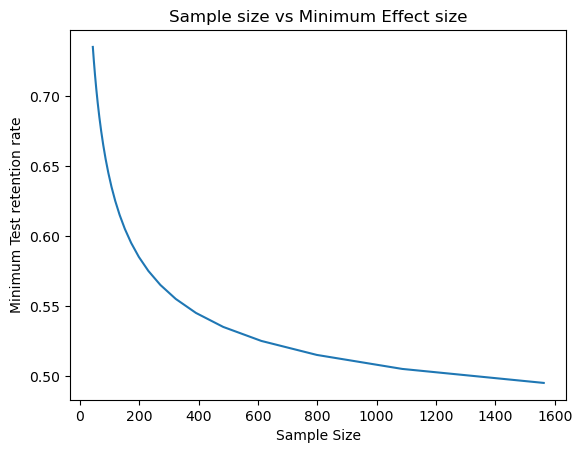

In [28]:
possible_p2 = np.arange(retention_mean+0.05, retention_mean+0.3, .01)  # possible p2 values with 0.5% increments

# estimate sample size & plot
sample_size = []
for i in possible_p2:
   p1_and_p2 = sms.proportion_effectsize(retention_mean, i)
   sample_size.append(sms.NormalIndPower().solve_power(p1_and_p2, power=0.8, alpha=0.05))
plt.plot(sample_size, possible_p2)
plt.title("Sample size vs Minimum Effect size")
plt.xlabel("Sample Size")
plt.ylabel("Minimum Test retention rate")
plt.show()

#### 4. Proportional Z test & confidence interval

In [16]:
#returning the total number of conversions for each group:
cont_retention_1 = len(df_control.loc[df_control['retention_1']==True])
test_retention_1 = len(df_test.loc[df_test['retention_1']==True])
successes = [cont_retention_1, test_retention_1]
nobs = [cont_size, test_size]
z_score, p_value = proportions_ztest(successes, nobs=nobs, alternative='larger', prop_var=0.5)

print("H0: Distributions of both populations are equal.")
print("H1: Distributions of both populations are not equal.\n")
print(f"Z test statistic is {z_score.round(5)}")
print(f"p-value for Z test is {p_value:.3f}\n")

if p_value<alpha:
    print(f"p-value={p_value}<{alpha}")
    print("We can reject null hypothesis. These groups are not similar. Users in Gate30 have higher 1 day retention than Gate40")
else:
    print(f"p-value={p_value}>={alpha}")
    print("We can't reject null hypothesis. These groups are similar.")

H0: Distributions of both populations are equal.
H1: Distributions of both populations are not equal.

Z test statistic is 1.77334
p-value for Z test is 0.038

p-value=0.038086008036115795<0.05
We can reject null hypothesis. These groups are not similar. Users in Gate30 have higher 1 day retention than Gate40


In [15]:
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_score:.2f}')
print(f'p-value: {p_value:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 1.77
p-value: 0.038
ci 95% for control group: [0.444, 0.453]
ci 95% for treatment group: [0.438, 0.447]


#### 5. Bootstrapping

'100.0%'

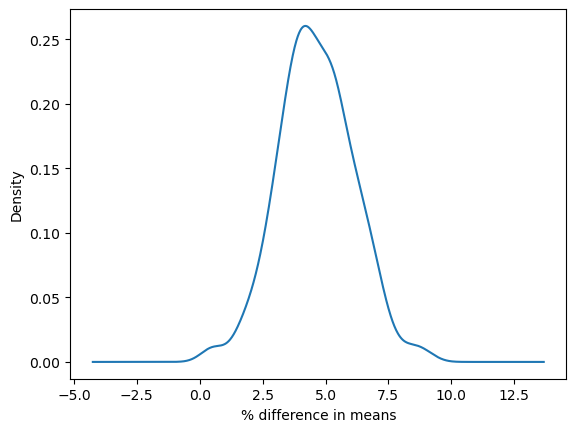

In [14]:
# Creating a list with bootstrapped means for each AB-group
boot_7d = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_7d = pd.DataFrame(boot_7d, columns=['gate_30', 'gate_40'])
# Adding a column with the % difference between the two AB-groups
boot_7d['diff'] = ((boot_7d['gate_30'] - boot_7d['gate_40'])/boot_7d['gate_40'])* 100
# Ploting the bootstrap % difference
ax = boot_7d['diff'].plot(kind='kde')
ax.set_xlabel("% difference in means")
# Calculating the probability that 7-day retention is greater when the gate is at level 30
prob = (boot_7d['diff'] > 0 ).mean()
# Pretty printing the probability
'{:.1%}'.format(prob)

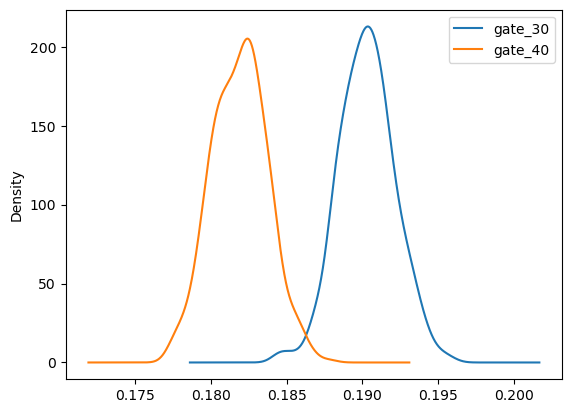

In [15]:
# A Kernel Density Estimate plot of the bootstrap distributions
boot_7d[['gate_30', 'gate_40']].plot(kind = 'kde')
plt.show()